# Digit Recognizer Competition 

**RESUMEN**

La base de datos del MNIST (base de datos modificada del Instituto Nacional de Normas y Tecnología) es una gran base de datos de dígitos manuscritos que se utiliza comúnmente para la capacitación de diversos sistemas de procesamiento de imágenes. La base de datos también se utiliza ampliamente para la capacitación y el ensayo en el campo del aprendizaje automático. Se creó "remezclando" las muestras de los conjuntos de datos originales del NIST.  Además, las imágenes en blanco y negro del NIST fueron normalizadas para que encajaran en un cuadro delimitador de 28x28 píxeles, lo que introdujo niveles de escala de grises.

La base de datos del MNIST contiene 42.000 imágenes de entrenamiento y 28.000 imágenes de prueba. En su papel original, utilizan una máquina de soporte vectorial para obtener una tasa de error del 0,8%. En 2017 se ha publicado un conjunto de datos ampliado similar al MNIST llamado EMNIST, que contiene 240.000 imágenes de entrenamiento y 40.000 imágenes de prueba de dígitos y caracteres escritos a mano.

**Este Cuaderno tiene tres partes principales:**

1. La preparación de datos
1. El modelado de la red convolucional
1. La predicción y submission de resultados

Importamos las librerías de tensorflow y keras para nuestro modelo de redes neuronales profundas. Y comprobamos la versión.

In [1]:
import tensorflow as tf
tf.__version__

'2.6.0'

In [2]:
from tensorflow import keras
keras.__version__

'2.6.0'

Añadimos más librerías

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

sns.set(style='white', context='notebook', palette='deep')

# Los archivos de datos están disponibles en el directorio "../input/" 

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/digit-recognizer/sample_submission.csv
/kaggle/input/digit-recognizer/train.csv
/kaggle/input/digit-recognizer/test.csv


Hay tres archivos que existen en este fichero: (1) train.csv, (2) test.csv, (3) sample_submission.csv 

En esta parte cargamos y visualizamos los datos que serán los pixeles de entrada para cada imagen. En esta celda cargamos el archivo train.csv.

In [4]:
train = pd.read_csv("../input/digit-recognizer/train.csv")
train.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Tenemos 785 columnas de características (cada pixel) y 42000 instancias de datos

In [5]:
print("Tamaño del dataset de entrenamiento", train.shape)

Tamaño del dataset de entrenamiento (42000, 785)


En esta celda cargamos el archivo test.csv.

In [6]:
test = pd.read_csv("../input/digit-recognizer/test.csv")
test.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Tenemos 784 columnas de características, ya que no contamos con la etiqueta final y 28000 instancias de datos. 

In [7]:
print("Tamaño del dataset de prueba", test.shape)

Tamaño del dataset de prueba (28000, 784)


Guardamos la etiqueta de salida en la variable y_train. Además quitamos la etiqueta del conjunto de datos

In [8]:
Y_train = train["label"]

X_train = train.drop(labels = ["label"],axis = 1) 

Y_train.head()

0    1
1    0
2    1
3    4
4    0
Name: label, dtype: int64

Realizamos una **visualización** de unas de las primeras imágenes con la etiqueta correspondiente que tienen.

In [9]:
sns.set(palette="tab10")
plt.rcParams['figure.dpi'] = 120

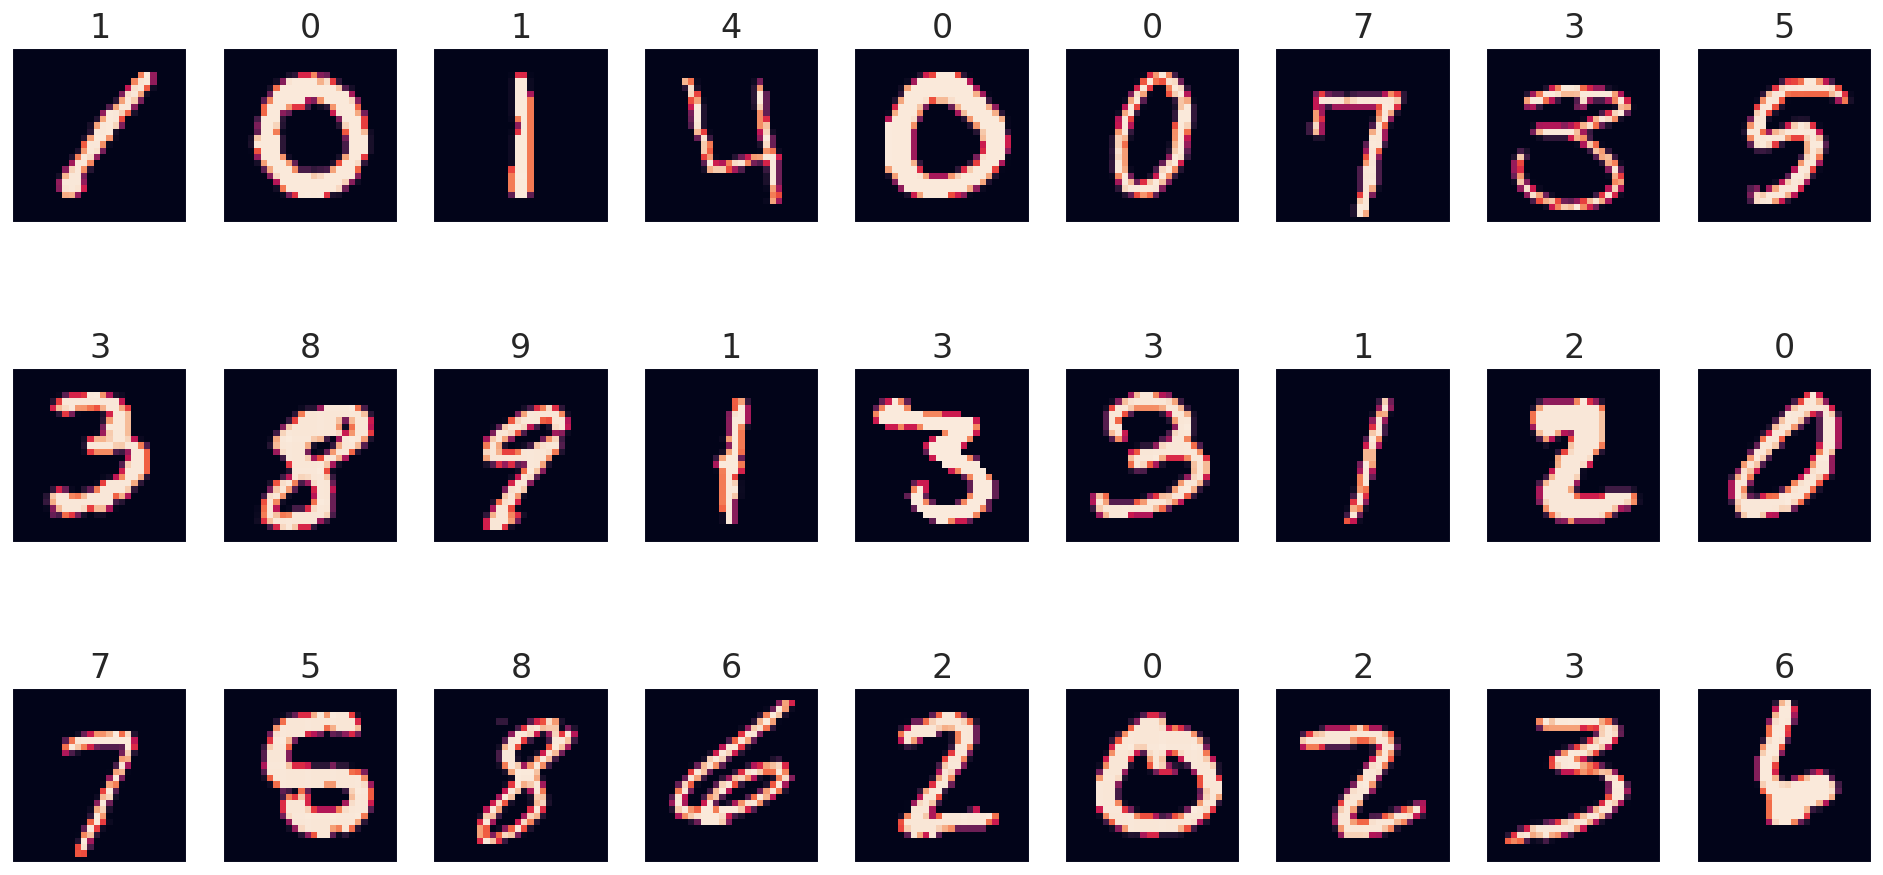

In [10]:
plt.figure(figsize=(20, 10))
for i in range(27):
    plt.subplot(3, 9, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_train.iloc[i].to_numpy().reshape((28,28,1)))
    plt.title(Y_train[i],size = 20)
plt.show()

Miramos el número de ejemplos por cada etiqueta de salida. Vemos que todas tienen un valor similar de 4000 ejemplos, pero realizamos un gráfico para verlo de manera más visual.

In [11]:
Y_train.value_counts()

1    4684
7    4401
3    4351
9    4188
2    4177
6    4137
0    4132
4    4072
8    4063
5    3795
Name: label, dtype: int64

Realizamos dos gráficos diferentes para visualizar el número de etiquetas de salida que podemos obtener en el problema. Que serán datos etiquetados del 1 al 10.

In [12]:
grafico = dict(train['label'].value_counts())
grafico = dict(sorted(grafico.items()))

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


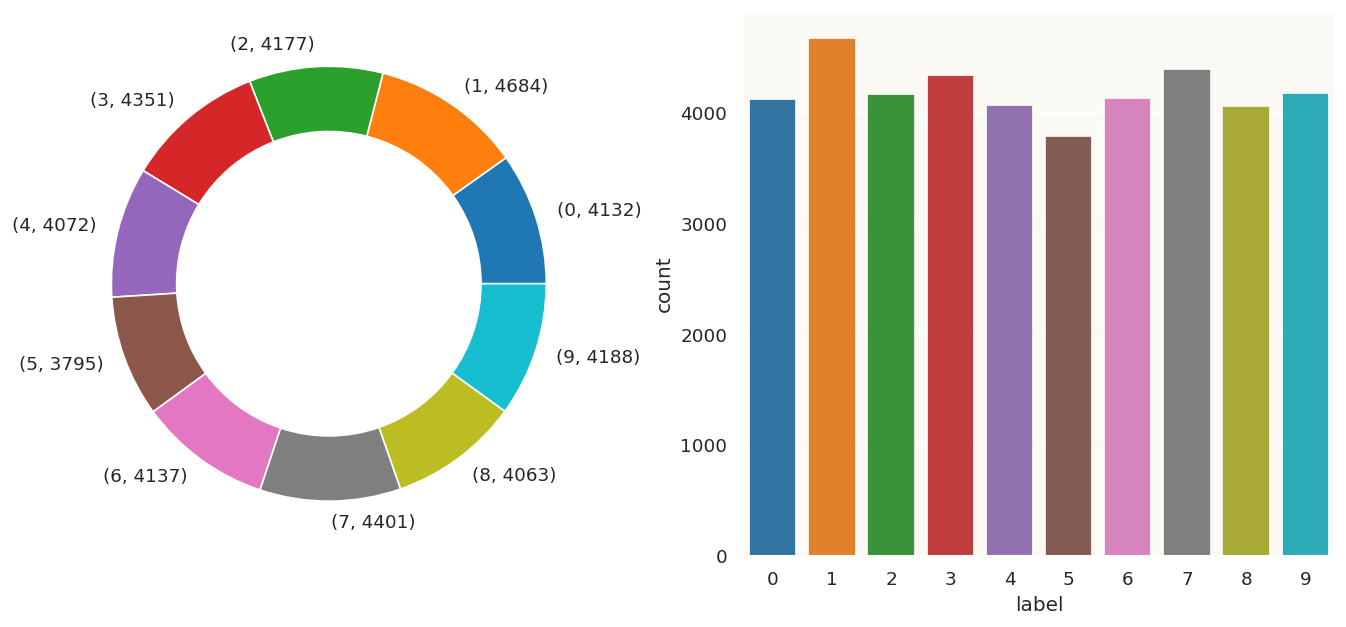

In [13]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize =(14,6))
background_color = '#faf9f4'
ax1.set_facecolor(background_color)
ax2.set_facecolor(background_color) 
ax1.pie(grafico.values(),wedgeprops=dict(width=0.3, edgecolor='w') ,labels=grafico.items(), radius=1)
ax2 = sns.countplot(train['label'])
plt.show()

Tenemos números similares para los 10 dígitos.

Vamos a comenzar a controlar el total de los valores nulos de las celdas.

In [14]:
X_train.isnull()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41995,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
41996,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
41997,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
41998,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


Contamos el número de valores nulos para cada columnas

In [15]:
print("Columnas nulas en conjunto de entrenamiento", X_train.isnull().sum())

Columnas nulas en conjunto de entrenamiento pixel0      0
pixel1      0
pixel2      0
pixel3      0
pixel4      0
           ..
pixel779    0
pixel780    0
pixel781    0
pixel782    0
pixel783    0
Length: 784, dtype: int64


In [16]:
X_train.isnull().any().describe()

count       784
unique        1
top       False
freq        784
dtype: object

No hay valores nulos en el conjunto de datos de prueba y test. Podemos seguir adelante sin problema. 

Realizamos un Normalización de los datos tanto en entrenamiento como test. Si realizamos la normalización, CNN funciona más rápido.

**Realizamos una normalización de escala de grises. De esta manera, a menudo se puede aumentar la claridad de la imagen.**

In [17]:
X_train = X_train / 255.0
test = test / 255.0

Se han almacenado imágenes de entrenamiento y prueba (28px x 28px) en un Dataframe de Pandas como vectores de 784 valores.

Realizamos además un reshape de los datos de entrada.
- Reformamos todos los datos en matrices 3D de 28x28x1.
- Keras necesita al final una dimensión extra que corresponde a los canales. Nuestras imágenes están en escala de grises, por lo que solo usan un canal.

In [18]:
X_train = X_train.values.reshape(-1,28,28,1)
test = test.values.reshape(-1,28,28,1)

print("Tamaño del dataset de entrenamiento", X_train.shape)
print("Tamaño del dataset de prueba", test.shape)

Tamaño del dataset de entrenamiento (42000, 28, 28, 1)
Tamaño del dataset de prueba (28000, 28, 28, 1)


Las etiquetas son números de 10 dígitos del 0 al 9. Necesitamos codificar las etiquetas en un one hot vectors ([0,0,1,0,0,0,0,0,0,0,0])

Un one-hot vector -> es 0 en la mayoría de las dimensiones y 1 en una sola dimensión.

In [19]:
from keras.utils.np_utils import to_categorical
Y_train = to_categorical(Y_train, num_classes = 10)

 Inicializamos la semilla para la división del conjunto de datos

In [20]:
random_seed = 2

Dividimos el conjunto de datos de entrenamiento y el conjunto de test.
- tamaño de entrenamiento es 90%
- tamaño de test es 10%

In [21]:
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size = 0.10, random_state=random_seed)

Miramos la longitud tras realizar la división

En el conjunto de entrenamiento tenemos 37800 datos

In [22]:
print(len(X_train))

37800


Mientras que en el conjunto de test tenemos 4200 datos

In [23]:
print(len(X_val))

4200


Definimos nuestro modelo CNN. Se utiliza para clasificación de imágenes.

In [24]:
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau

La extracción de características consta de tres operaciones básicas:
1. Filtrar una imagen para una característica en particular (convolución)
2. Detecta esa característica dentro de la imagen filtrada (ReLU)
3. Condensar la imagen para mejorar las características (maximum pooling)

-------------------------------------------------------------------------------------------------------------
Una capa convolucional realiza el paso de filtrado. Los pesos que aprende una capa convolucional los llamamos kernels. Funciona escaneando una imagen y produciendo una suma ponderada de valores de píxeles.

Los kernels definen cómo se conecta una capa convolucional a la capa que sigue. Al establecer las dimensiones de los kernels con kernel_size, le está diciendo al convnet cómo formar estas conexiones. La mayoría de las veces, un kernel tendrá dimensiones impares, como kernel_size = (3, 3) o (5, 5)

Los kernels en una capa convolucional determinan qué tipo de características crea. Durante el entrenamiento, un convnet intenta aprender qué características necesita para resolver el problema de clasificación.

-------------------------------------------------------------------------------------------------------------

Las activaciones en la red las llamamos feature maps. Resultan cuando aplicamos un filtro a una imagen; ya que contienen las características visuales del kernel. En este caso utilizamos la función ReLU.

La activación de ReLU dice que los valores negativos no son importantes y, por lo tanto, los establece en 0.

------------------------------------------------------------------------------------------------------------

La última es la de maximum pooling, que en Keras se realiza mediante una capa.

Una capa MaxPool2D sa una función máxima  en lugar de un kernel, con el parámetro pool_size. Sin embargo, una capa MaxPool2D no tiene pesos entrenables.

Después de aplicar la función ReLU, el mapa de características termina con una gran cantidad de "espacio muerto", es decir, áreas grandes que contienen solo ceros. Hay que condensar el mapa de características para retener solo la parte más útil.
La agrupación máxima toma las activaciones en el mapa de características  y las reemplaza con la activación máxima.

In [25]:
model = Sequential()

model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', activation ='relu', input_shape = (28,28,1)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', activation ='relu'))
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(10, activation = "softmax"))


User settings:

   KMP_AFFINITY=granularity=fine,verbose,compact,1,0
   KMP_BLOCKTIME=0
   KMP_DUPLICATE_LIB_OK=True
   KMP_INIT_AT_FORK=FALSE
   KMP_SETTINGS=1
   KMP_WARNINGS=0

Effective settings:

   KMP_ABORT_DELAY=0
   KMP_ADAPTIVE_LOCK_PROPS='1,1024'
   KMP_ALIGN_ALLOC=64
   KMP_ALL_THREADPRIVATE=128
   KMP_ATOMIC_MODE=2
   KMP_BLOCKTIME=0
   KMP_CPUINFO_FILE: value is not defined
   KMP_DETERMINISTIC_REDUCTION=false
   KMP_DEVICE_THREAD_LIMIT=2147483647
   KMP_DISP_NUM_BUFFERS=7
   KMP_DUPLICATE_LIB_OK=true
   KMP_ENABLE_TASK_THROTTLING=true
   KMP_FORCE_REDUCTION: value is not defined
   KMP_FOREIGN_THREADS_THREADPRIVATE=true
   KMP_FORKJOIN_BARRIER='2,2'
   KMP_FORKJOIN_BARRIER_PATTERN='hyper,hyper'
   KMP_GTID_MODE=3
   KMP_HANDLE_SIGNALS=false
   KMP_HOT_TEAMS_MAX_LEVEL=1
   KMP_HOT_TEAMS_MODE=0
   KMP_INIT_AT_FORK=true
   KMP_LIBRARY=throughput
   KMP_LOCK_KIND=queuing
   KMP_MALLOC_POOL_INCR=1M
   KMP_NUM_LOCKS_IN_BLOCK=1
   KMP_PLAIN_BARRIER='2,2'
   KMP_PLAIN_BARRIER_P

Comprobamos cual es el resumen de las capas de nuestro modelo

In [26]:
 model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 32)        832       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 32)        25632     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 14, 14, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 64)          0

La primera es la capa convolucional (Conv2D). Establecí 32 filtros para las dos primeras y 64 filtros para las dos últimas. La matriz de filtro de kernel se aplica a toda la imagen. 

La segunda capa importante es la capa MaxPool2D. Esta capa simplemente actúa como un filtro de reducción de resolución. Elige el valor máximo. Estos se utilizan para reducir el costo computacional.

Se usan capas de Dropout, donde una proporción se ignora aleatoriamente (estableciendo sus pesos en cero) para cada muestra de entrenamiento. Esta técnica  reduce el sobreajuste.

La capa Flatten se utiliza para convertir los mapas de características finales en un solo vector 1D.

En la última capa (activación = "softmax") -> probabilidad de cada clase en la salida.

In [27]:
optimizer = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)

- Definimos la función de pérdida para medir el rendimiento de nuestro modelo.

- La función más importante es el optimizador. Esta función mejorará iterativamente los  los valores del kernel y los pesos  para minimizar la pérdida. RMSprop  o Adam son optimizadores muy efectivos.

- La función métrica "accuracy" 

In [28]:
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

Para hacer que el optimizador converja más rápido se utiliza una tasa de aprendizaje decreciente durante el entrenamiento para alcanzar de manera eficiente el mínimo global de la función de pérdida.

En este caso se disminuye el LR cada epoch dependiendo de si es necesario. Para ello se utiliza los callbacks.

In [29]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

La mejor forma de mejorar el rendimiento de un modelo de aprendizaje automático es entrenarlo con más datos. 

Una forma sencilla de obtener más datos es utilizar los datos que ya tiene. Si podemos transformar las imágenes en nuestro conjunto de datos de manera que conserven la clase, podemos enseñar a nuestro clasificador a ignorar ese tipo de transformaciones. 

Y esa es toda la idea detrás del aumento de datos: agregar algunos datos falsos adicionales que se parezcan razonablemente a los datos reales y el clasificador mejorará.

In [30]:
datagen = ImageDataGenerator(
        featurewise_center=False,  
        samplewise_center=False,  
        featurewise_std_normalization=False,  
        samplewise_std_normalization=False,  
        zca_whitening=False,  
        rotation_range=10, 
        zoom_range = 0.1,
        width_shift_range=0.1,  
        height_shift_range=0.1,  
        horizontal_flip=False, 
        vertical_flip=False)  

- Rote aleatoriamente algunas imágenes 
- Zoom aleatorio algunas imágenes de entrenamiento
- Cambiar las imágenes en un 10% del ancho
- Cambiar las imágenes verticalmente en un 10% de la altura
- etc ...

DESPUES ENTRENAMOS EL CONJUNTO DE DATOS DE ENTRENAMIENTO

In [31]:
datagen.fit(X_train)

Entrenamos nuestro modelo pasándole el conjunto de características de entramiento y la salida final.

Un tamaño de batch_size = 80 es habitual. Y con 30 epochs.

In [32]:
history = model.fit(datagen.flow(X_train,Y_train, batch_size=86),
                              epochs = 1, validation_data = (X_val,Y_val),
                              verbose = 2, steps_per_epoch=X_train.shape[0], 
                              callbacks=[learning_rate_reduction])

2021-11-15 10:06:34.070452: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


37800/37800 - 83s - loss: 0.4164 - accuracy: 0.8663 - val_loss: 0.0645 - val_accuracy: 0.9795


In [33]:
print('Loss     : {} \nAccuracy : {}'.format(history.history['loss'][-1],history.history['accuracy'][-1]))

Loss     : 0.41637954115867615 
Accuracy : 0.8662962913513184


Predecimos los resultados para el cojunto de datos de test. Una vez realizado el entrenamiento, le pasamos al modelo nuevos ejemplos que no ha visto para que realice una predicción.

In [34]:
Y_pred = model.predict(X_val)

In [35]:
Y_pred_classes = np.argmax(Y_pred ,axis = 1) 
Y_true = np.argmax(Y_val, axis=1)

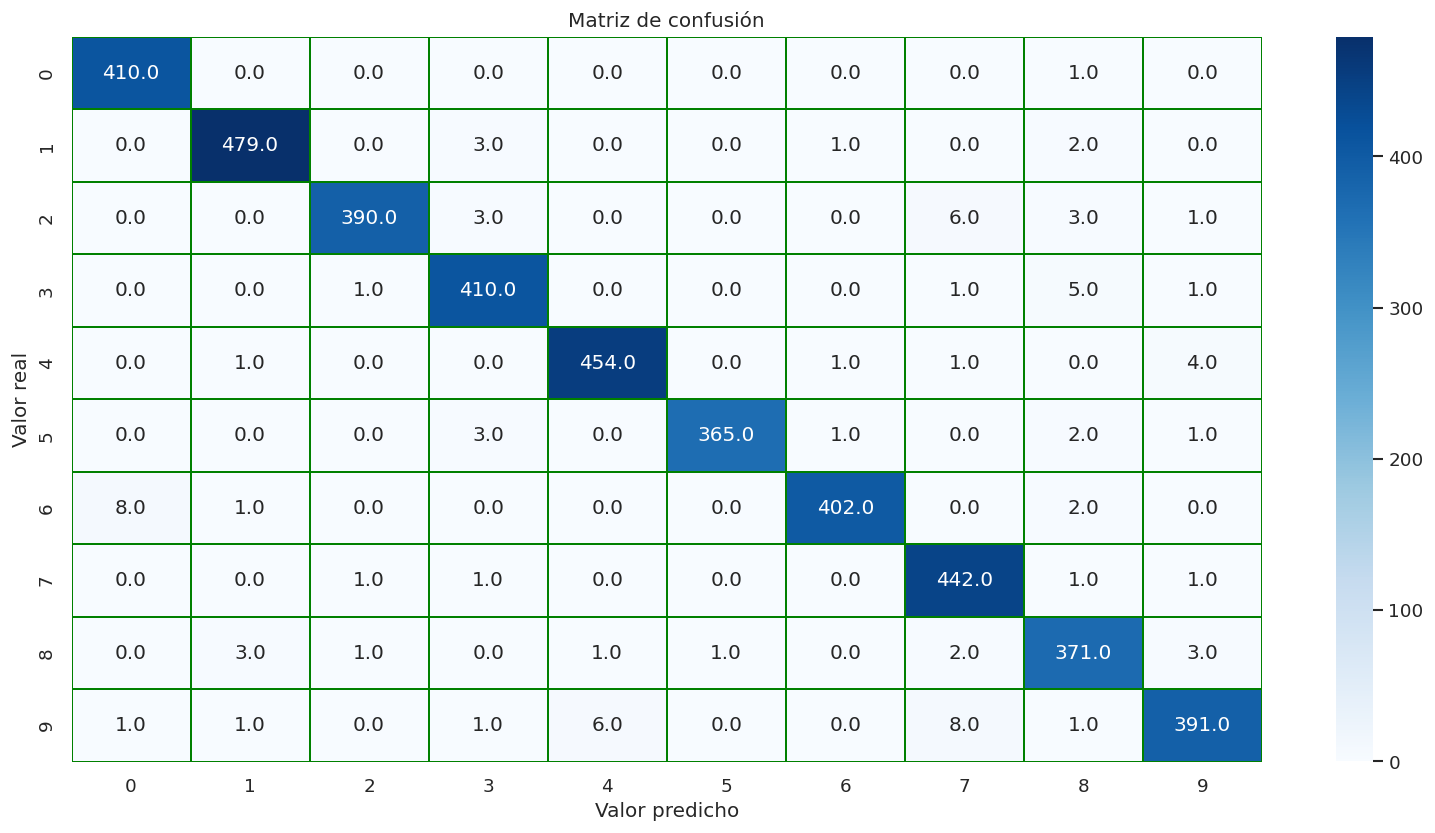

In [36]:
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)
f,ax = plt.subplots(figsize=(16,8))
sns.heatmap(confusion_mtx, annot=True, linewidths=0.01, cmap="Blues", linecolor="Green", fmt='.1f', ax=ax)
plt.xlabel("Valor predicho")
plt.ylabel("Valor real")
plt.title("Matriz de confusión")
plt.show()

Representamos algunas de las imágenes con el valor predecido para ver si es correcto.

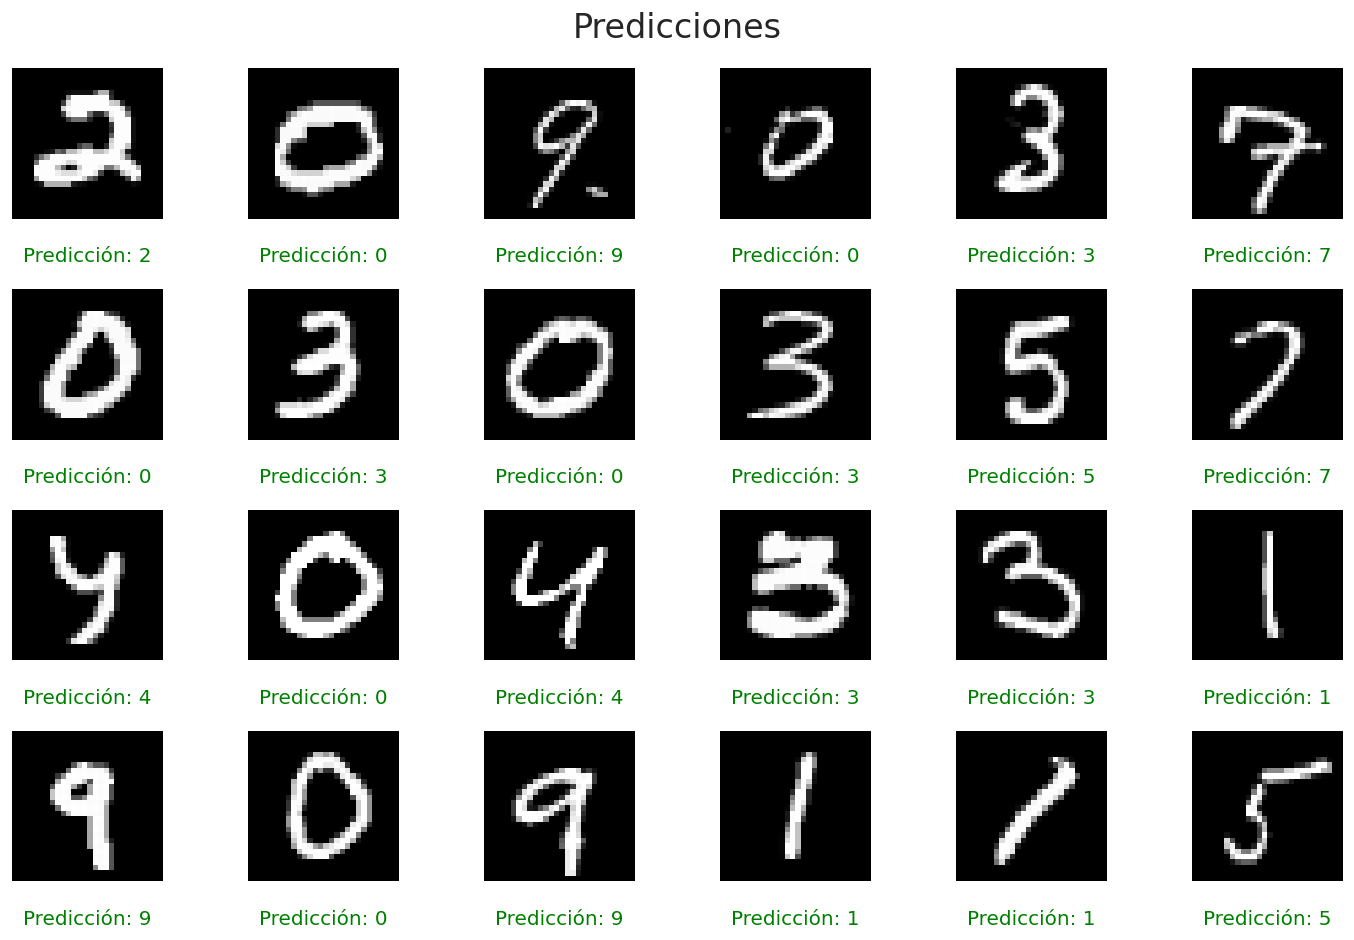

In [37]:
Y_pred = model.predict(test)
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
rows = 4
cols = 6
f = plt.figure(figsize=(2*cols,2*rows))
f.suptitle("Predicciones", fontsize=20)
for i in range(rows*cols): 
    f.add_subplot(rows,cols,i+1)
    img = test[i]
    img = img.reshape((28,28))
    plt.imshow(img,
               cmap='gray')
    plt.axis("off")
    plt.title("Predicción: {}".format(Y_pred_classes[i]),
              y=-0.35,color="green")
f.tight_layout()
    
f.show()

Guardamos en archivo de submission los resultados

In [38]:
submission = pd.DataFrame({'ImageId': range(1,28001), 'Label': Y_pred_classes})
submission.to_csv('submission.csv', index=False)

In [39]:
submission

,ImageId,Label
0,1,2
1,2,0
2,3,9
3,4,0
4,5,3
...,...,...
27995,27996,9
27996,27997,7
27997,27998,3
27998,27999,9
